In [1]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve,auc
from elm import ELMClassifier,GenELMClassifier,BaseELM
from random_layer import RandomLayer,MLPRandomLayer,RBFRandomLayer,GRBFRandomLayer

import numpy as np
import pandas as pd
import seaborn
import data_util as data


# 335 OTUs in total and 490 samples
# otuinfile = 'glne007.final.an.unique_list.0.03.subsample.0.03.filter.shared'
# mapfile = 'metadata.tsv'
# disease_col = 'dx'
# 
# # Data reading
# data = pd.read_table(otuinfile,sep='\t',index_col=1)
# filtered_data = data.dropna(axis='columns', how='all')
# X = filtered_data.drop(['label','numOtus'],axis=1)
# metadata = pd.read_table(mapfile,sep='\t',index_col=0)
# y = metadata[disease_col]
# # Inner join metadata and OTU
# merge = pd.concat([X, y], axis=1,join='inner')
# # Filter adenoma
# merge = merge.loc[merge[disease_col].isin(['normal','cancer'])]
# 
# y = merge[disease_col]
# X = merge.drop([disease_col],axis=1)

/home/qiang/anaconda3/envs/TFMicrobiome/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# encoder = LabelEncoder()
# y = pd.Series(encoder.fit_transform(y),
# index=y.index, name=y.name)
# 
# A, P, Y, Q = train_test_split(
# X, y, test_size=0.15, random_state=42)	# Can change to 0.2

A, P, Y, Q = data.colorectal_adenoma_cancer_data()

clf = RandomForestClassifier(
	n_estimators=7000,random_state=0,criterion='entropy',min_samples_split=20).fit(A, Y.values.ravel())
print ("Accuracy of Random Forest Classifier: "+str(clf.score(P,Q)))

# algorithm, learning_rate_init, alpha, hidden_layer_sizes 
# and activation have impact
clf2 = MLPClassifier(solver='adam', alpha=0.01, max_iter=1000,
	learning_rate='adaptive', hidden_layer_sizes=(400,), 
	random_state=0, learning_rate_init=1e-2,
	activation='logistic').fit(A, Y.values.ravel())
print ("Accuracy of Multi-layer Perceptron Classifier: "+str(clf2.score(P,Q)))

clf3 = GradientBoostingClassifier(n_estimators=1000, learning_rate=1,
max_depth=10, random_state=0, min_samples_split=5).fit(A, Y.values.ravel())
print ("Accuracy of Gradient Boosting Classifier: "+str(clf3.score(P,Q)))

clf4 = SVC(kernel='rbf',C=1,
	gamma=0.001,random_state=0,probability=True).fit(A, Y.values.ravel())
print ("Accuracy of SVM: "+str(clf4.score(P,Q)))

clf5 = GaussianNB().fit(A, Y.values.ravel())
print ("Accuracy of Gaussian Naive Bayes Classifier: "+str(clf5.score(P,Q)))

srhl_rbf = RBFRandomLayer(n_hidden=50,rbf_width=0.1,random_state=0)
clf6 = GenELMClassifier(hidden_layer=srhl_rbf).fit(A, Y.values.ravel())
print ("Accuracy of Extreme learning machine Classifier: "+str(clf6.score(P,Q)))

Accuracy of Random Forest Classifier: 0.75
Accuracy of Multi-layer Perceptron Classifier: 0.7045454545454546
Accuracy of Gradient Boosting Classifier: 0.7045454545454546
Accuracy of SVM: 0.5227272727272727
Accuracy of Gaussian Naive Bayes Classifier: 0.75
Accuracy of Extreme learning machine Classifier: 0.5227272727272727


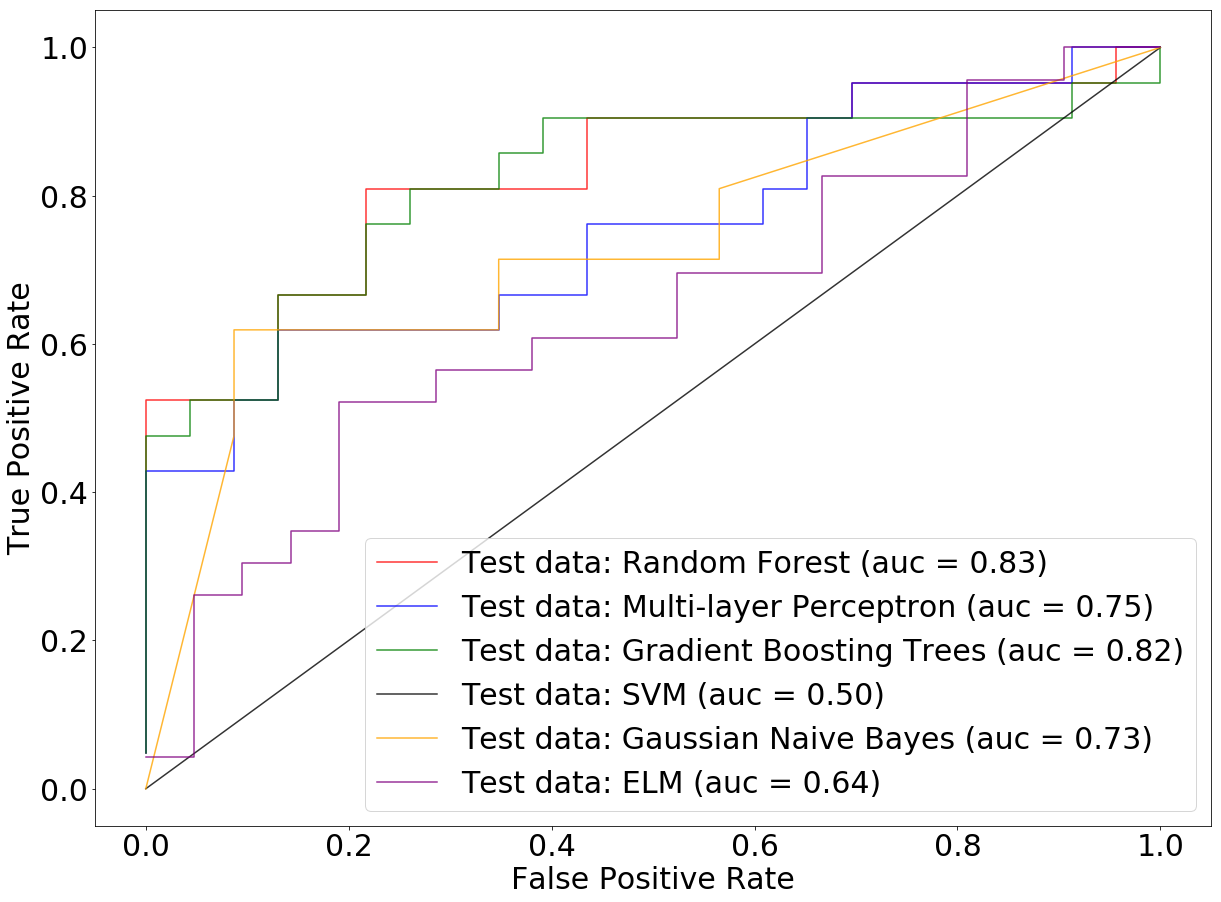

In [3]:
%matplotlib inline
# Only 2-class problem
cls = 0
# Set figure size and plot layout
figsize=(20,15)
f, ax = plt.subplots(1, 1, figsize=figsize)

params = [(clf,'red',"Random Forest"),(clf2,'blue',"Multi-layer Perceptron"),(clf3,'green',"Gradient Boosting Trees"),
         (clf4,'black',"SVM"),(clf5,'orange','Gaussian Naive Bayes'),(clf6,'purple','ELM')]

for x in params:
    if isinstance(x[0], BaseELM):
        y_score = x[0].decision_function(P)
        fpr, tpr, _ = roc_curve(Q, y_score)
        roc_auc = auc(fpr, tpr)
    else:
        y_true = Q[Q.argsort().index]
        y_prob = x[0].predict_proba(P.ix[Q.argsort().index,:])
        fpr, tpr, _ = roc_curve(y_true, y_prob[:, cls], pos_label=cls)
        roc_auc = roc_auc_score(y_true == cls, y_prob[:, cls]) 
    ax.plot(fpr, tpr, color=x[1], alpha=0.8,
    label='Test data: {} '
    '(auc = {:.2f})'.format(x[2] ,roc_auc))

ax.set_xlabel('False Positive Rate',fontsize=30)
ax.set_ylabel('True Positive Rate',fontsize=30)
ax.legend(loc="lower right",fontsize=30)
ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=30)

In [9]:
# # Data reading
# data = pd.read_table(otuinfile,sep='\t',index_col=1)
# filtered_data = data.dropna(axis='columns', how='all')
# X = filtered_data.drop(['label','numOtus'],axis=1)
# metadata = pd.read_table(mapfile,sep='\t',index_col=0)
# y = metadata[disease_col]
# ## Merge adenoma and normal in one-category called no-cancer, so we have binary classification
# y = y.replace(to_replace=['normal','adenoma'], value=['no-cancer','no-cancer'])
# 
# encoder = LabelEncoder()
# y = pd.Series(encoder.fit_transform(y),
# index=y.index, name=y.name)


In [10]:
# A, P, Y, Q = train_test_split(
# X, y, test_size=0.15, random_state=42)	# Can change to 0.2

A, P, Y, Q = data.t2d_data()

clf = RandomForestClassifier(
	n_estimators=7000,random_state=0,criterion='entropy',min_samples_split=20).fit(A, Y.values.ravel())
print ("Accuracy of Random Forest Classifier: "+str(clf.score(P,Q)))

# algorithm, learning_rate_init, alpha, hidden_layer_sizes 
# and activation have impact
clf2 = MLPClassifier(solver='adam', alpha=0.01, max_iter=1000,
	learning_rate='adaptive', hidden_layer_sizes=(400,), 
	random_state=0, learning_rate_init=1e-2,
	activation='logistic').fit(A, Y.values.ravel())
print ("Accuracy of Multi-layer Perceptron Classifier: "+str(clf2.score(P,Q)))

clf3 = GradientBoostingClassifier(n_estimators=1000, learning_rate=1,
max_depth=10, random_state=0, min_samples_split=5).fit(A, Y.values.ravel())
print ("Accuracy of Gradient Boosting Classifier: "+str(clf3.score(P,Q)))

clf4 = SVC(kernel='rbf',C=1,
	gamma=0.001,random_state=0,probability=True).fit(A, Y.values.ravel())
print ("Accuracy of SVM: "+str(clf4.score(P,Q)))

clf5 = GaussianNB().fit(A, Y.values.ravel())
print ("Accuracy of Gaussian Naive Bayes Classifier: "+str(clf5.score(P,Q)))

srhl_rbf = RBFRandomLayer(n_hidden=50,rbf_width=0.1,random_state=0)
clf6 = GenELMClassifier(hidden_layer=srhl_rbf).fit(A, Y.values.ravel())
print ("Accuracy of Extreme learning machine Classifier: "+str(clf6.score(P,Q)))

Accuracy of Random Forest Classifier: 0.5
Accuracy of Multi-layer Perceptron Classifier: 0.5789473684210527
Accuracy of Gradient Boosting Classifier: 0.5
Accuracy of SVM: 0.5263157894736842
Accuracy of Gaussian Naive Bayes Classifier: 0.4473684210526316
Accuracy of Extreme learning machine Classifier: 0.631578947368421


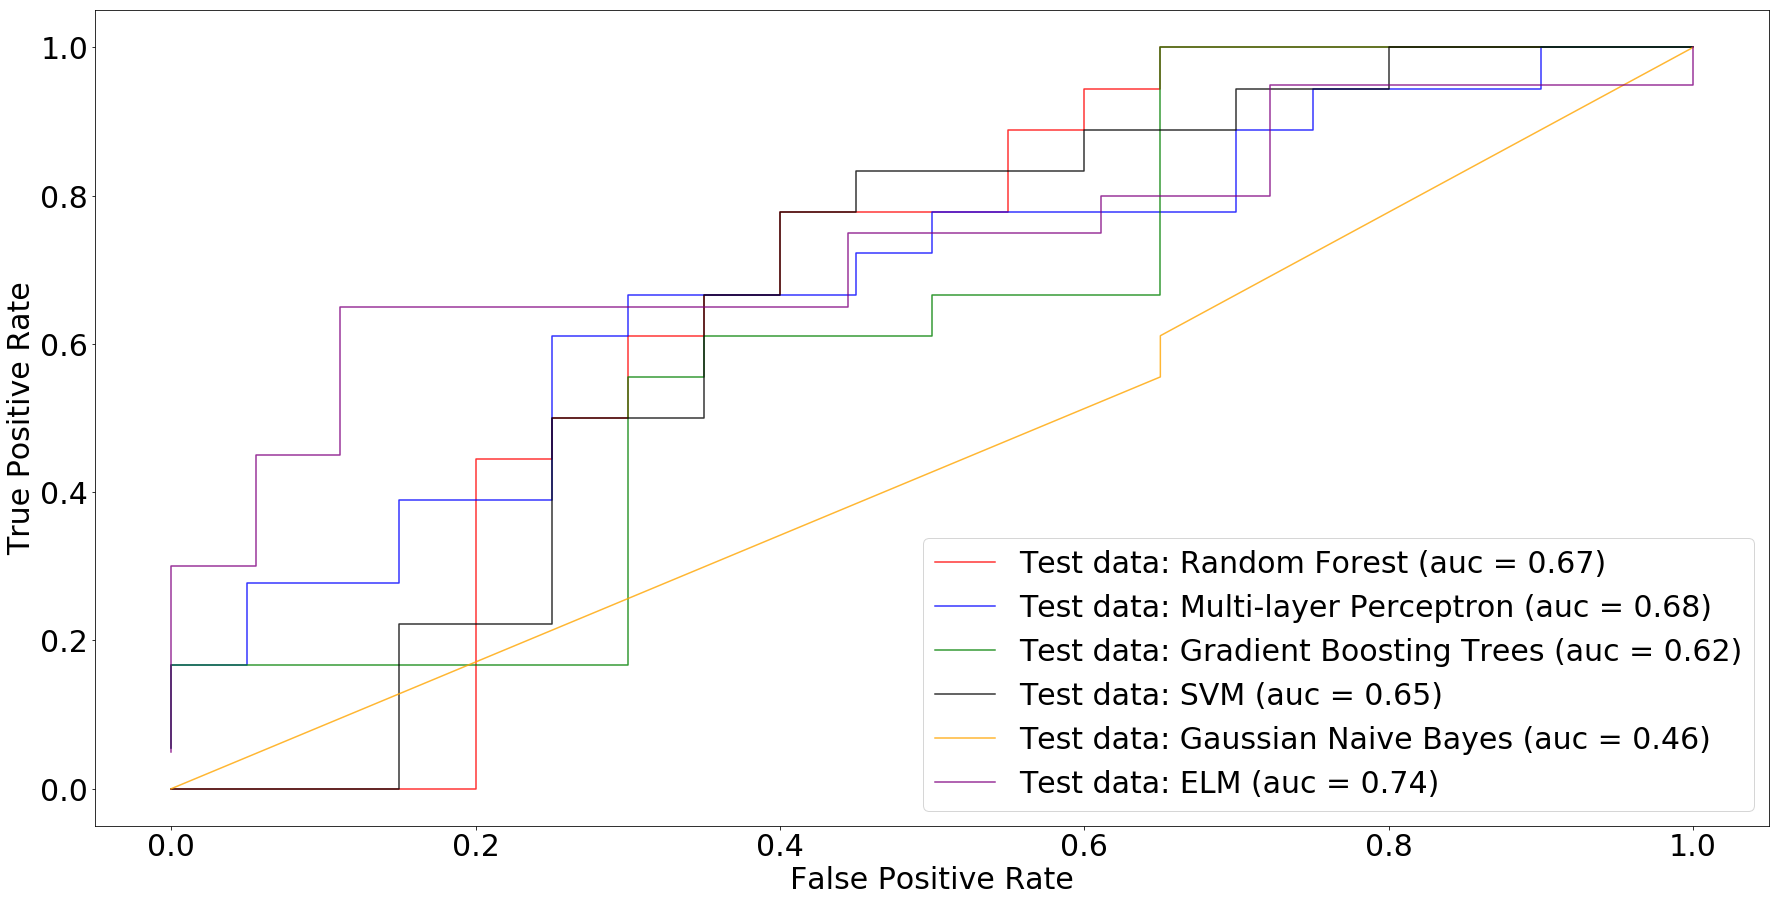

In [11]:
%matplotlib inline
# Only 2-class problem
cls = 0
# Set figure size and plot layout
figsize=(30,15)
f, ax = plt.subplots(1, 1, figsize=figsize)

params = [(clf,'red',"Random Forest"),(clf2,'blue',"Multi-layer Perceptron"),(clf3,'green',"Gradient Boosting Trees"),
         (clf4,'black',"SVM"),(clf5,'orange','Gaussian Naive Bayes'),(clf6,'purple','ELM')]
i=0
for x in params:
    if isinstance(x[0], BaseELM):
        y_score = x[0].decision_function(P)
        fpr, tpr, _ = roc_curve(Q, y_score)
        roc_auc = auc(fpr, tpr)
    else:
        y_true = Q[Q.argsort().index]
        y_prob = x[0].predict_proba(P.ix[Q.argsort().index,:])
        fpr, tpr, _ = roc_curve(y_true, y_prob[:, cls], pos_label=cls)
        roc_auc = roc_auc_score(y_true == cls, y_prob[:, cls]) 
    ax.plot(fpr, tpr, color=x[1], alpha=0.8,
    label='Test data: {} '
    '(auc = {:.2f})'.format(x[2] ,roc_auc))


ax.set_xlabel('False Positive Rate',fontsize=30)
ax.set_ylabel('True Positive Rate',fontsize=30)
ax.legend(loc="lower right",fontsize=30)
ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=30)